Variational Auto-Encoders
=========================
This code implements a Variation Auto-Encoder (VAE). If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [ ]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118 #uncomment to enforce cuda 11.8

if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm


%matplotlib inline
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from matplotlib import gridspec

import os
if os.path.exists('./training') == False:
  os.mkdir('./training')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Hyper-Parameters
----------------

In [ ]:
batch_size = 3000     # batch size
latent_dim = 100      # latent-space dimension
middle_dim = 128      # size of the middle layer
learning_rate = 1e-3  # learning rate
max_epochs = 50       # maximum number of epochs
use_gpu = True        # using the GPU

Loading the Dataset
-------------------
As in the GAN example, we will be using the MNIST dataset. MNIST images show digits from 0-9 in 28x28 grayscale images.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.ToTensor()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# image dimensions
input_dim = 28**2

100%|██████████| 9.91M/9.91M [00:00<00:00, 51.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]


VAE Definition
--------------
We will now use a specific scheme to initialize our weights, called Xavier initialization. You can neglect this if you are using other layers than fully connected.

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

The following model represents the distribution encoder distribution q(z|x), together with the reparametrization trick.

In [ ]:
class Q(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(Q, self).__init__()
    self.lin_middle = nn.Linear(input_dim, middle_dim, bias=True)
    self.lin_mu = nn.Linear(middle_dim, latent_dim, bias=True)
    self.lin_var = nn.Linear(middle_dim, latent_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_middle)
    init_weights(self.lin_mu)
    init_weights(self.lin_var)

  def forward(self, input):
    # forward
    middle = F.relu(self.lin_middle(input))
    z_mu = self.lin_mu(middle)
    z_var = self.lin_var(middle)
    return z_mu, z_var

We now model the reparametrization trick.

In [ ]:
class Reparametrization(nn.Module):
  def __init__(self):
    super(Reparametrization, self).__init__()

  def forward(self, z_mu, z_var):
    eps = torch.randn(z_var.size(0), z_var.size(1), device=device) # sample on a unit Gaussian
    return z_mu + torch.exp(z_var/2) * eps

The following model represents the decoder P(x|z).

In [ ]:
class P(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(P, self).__init__()
    self.lin_latent = nn.Linear(latent_dim, middle_dim, bias=True)
    self.lin_middle = nn.Linear(middle_dim, input_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_latent)
    init_weights(self.lin_middle)

  def forward(self, latent):
    middle = F.relu(self.lin_latent(latent))
    return F.sigmoid(self.lin_middle(middle))

Training
--------

We first initialize an instance of the model and load it onto GPU if relevant.

In [ ]:
# creating instances of the model
p = P(input_dim, middle_dim, latent_dim)
q = Q(input_dim, middle_dim, latent_dim)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the CPU.
Number of parameters for encoder: 114064 and decoder: 126280


We can now do the training properly speaking.

/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training...


Epoch 0: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


	[Losses] Total 2.61 - Recon. 2.48 - KL 0.128


Epoch 1: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


	[Losses] Total 1.56 - Recon. 1.44 - KL 0.123


Epoch 2: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


	[Losses] Total 1.43 - Recon. 1.32 - KL 0.104


Epoch 3: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


	[Losses] Total 1.34 - Recon. 1.23 - KL 0.111


Epoch 4: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


	[Losses] Total 1.26 - Recon. 1.14 - KL 0.124


Epoch 5: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


	[Losses] Total 1.21 - Recon. 1.08 - KL 0.129


Epoch 6: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


	[Losses] Total 1.17 - Recon. 1.04 - KL 0.132


Epoch 7: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


	[Losses] Total 1.15 - Recon. 1.01 - KL 0.134


Epoch 8: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


	[Losses] Total 1.12 - Recon. 0.982 - KL 0.139


Epoch 9: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


	[Losses] Total 1.1 - Recon. 0.956 - KL 0.142


Epoch 10: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


	[Losses] Total 1.08 - Recon. 0.934 - KL 0.145


Epoch 11: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


	[Losses] Total 1.06 - Recon. 0.918 - KL 0.146


Epoch 12: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


	[Losses] Total 1.05 - Recon. 0.899 - KL 0.148


Epoch 13: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


	[Losses] Total 1.04 - Recon. 0.886 - KL 0.15


Epoch 14: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


	[Losses] Total 1.02 - Recon. 0.871 - KL 0.151


Epoch 15: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


	[Losses] Total 1.01 - Recon. 0.858 - KL 0.153


Epoch 16: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


	[Losses] Total 1.0 - Recon. 0.847 - KL 0.154


Epoch 17: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


	[Losses] Total 0.991 - Recon. 0.836 - KL 0.154


Epoch 18: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


	[Losses] Total 0.984 - Recon. 0.828 - KL 0.156


Epoch 19: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


	[Losses] Total 0.973 - Recon. 0.817 - KL 0.156


Epoch 20: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


	[Losses] Total 0.966 - Recon. 0.809 - KL 0.157


Epoch 21: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


	[Losses] Total 0.958 - Recon. 0.801 - KL 0.157


Epoch 22: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


	[Losses] Total 0.952 - Recon. 0.795 - KL 0.157


Epoch 23: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


	[Losses] Total 0.946 - Recon. 0.788 - KL 0.158


Epoch 24: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


	[Losses] Total 0.94 - Recon. 0.782 - KL 0.158


Epoch 25: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


	[Losses] Total 0.932 - Recon. 0.774 - KL 0.158


Epoch 26: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


	[Losses] Total 0.928 - Recon. 0.77 - KL 0.158


Epoch 27: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


	[Losses] Total 0.922 - Recon. 0.763 - KL 0.159


Epoch 28: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


	[Losses] Total 0.917 - Recon. 0.759 - KL 0.158


Epoch 29: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


	[Losses] Total 0.912 - Recon. 0.753 - KL 0.159


Epoch 30: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


	[Losses] Total 0.904 - Recon. 0.745 - KL 0.159


Epoch 31: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


	[Losses] Total 0.903 - Recon. 0.744 - KL 0.159


Epoch 32: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


	[Losses] Total 0.894 - Recon. 0.735 - KL 0.159


Epoch 33: 100%|██████████| 20/20 [00:12<00:00,  1.67it/s]


	[Losses] Total 0.893 - Recon. 0.733 - KL 0.16


Epoch 34: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


	[Losses] Total 0.886 - Recon. 0.726 - KL 0.16


Epoch 35: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


	[Losses] Total 0.881 - Recon. 0.721 - KL 0.16


Epoch 36: 100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


	[Losses] Total 0.877 - Recon. 0.717 - KL 0.16


Epoch 37: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


	[Losses] Total 0.876 - Recon. 0.716 - KL 0.16


Epoch 38: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


	[Losses] Total 0.869 - Recon. 0.708 - KL 0.16


Epoch 39: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


	[Losses] Total 0.865 - Recon. 0.705 - KL 0.161


Epoch 40: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


	[Losses] Total 0.86 - Recon. 0.7 - KL 0.161


Epoch 41: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


	[Losses] Total 0.857 - Recon. 0.697 - KL 0.161


Epoch 42: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


	[Losses] Total 0.855 - Recon. 0.694 - KL 0.161


Epoch 43: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


	[Losses] Total 0.849 - Recon. 0.688 - KL 0.161


Epoch 44: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


	[Losses] Total 0.846 - Recon. 0.686 - KL 0.161


Epoch 45: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


	[Losses] Total 0.843 - Recon. 0.682 - KL 0.161


Epoch 46: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


	[Losses] Total 0.842 - Recon. 0.681 - KL 0.161


Epoch 47: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


	[Losses] Total 0.836 - Recon. 0.675 - KL 0.161


Epoch 48: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


	[Losses] Total 0.835 - Recon. 0.674 - KL 0.161


Epoch 49: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

	[Losses] Total 0.828 - Recon. 0.667 - KL 0.161
Done.


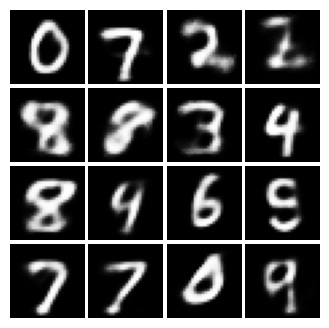

In [ ]:
# set models to train mode
p.train()
q.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.5, 0.999))
bce = nn.BCELoss(size_average=False, reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):

  avg_total_loss = 0
  avg_recon_loss = 0
  avg_kl_loss = 0

  for _, (batch, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
    batch = batch.to(device) # load the data onto GPU is relevant
    batch = batch.view(batch_size, -1)

    # forward
    z_mu, z_var = q(batch)
    z = reparam(z_mu, z_var)
    batch_recon = p(z)

    # reconstruction loss E[log P(X|z)]
    recon_loss = bce(batch_recon, batch) / len(batch)
    # distribution loss D_KL(Q(z|X) || P(z))
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
    # Total loss
    total_loss = recon_loss + kl_loss

    # backward
    total_loss.backward()

    # update
    optim.step()

    # housekeeping
    optim.zero_grad()
    avg_total_loss += total_loss / len(batch)
    avg_recon_loss += recon_loss / len(batch)
    avg_kl_loss += kl_loss / len(batch)

  # end of epoch
  total_losses.append(avg_total_loss.item())
  recon_losses.append(avg_recon_loss.item())
  kl_losses.append(avg_kl_loss.item())
  print(f"\t[Losses] Total {total_losses[-1]:.3} - Recon. {recon_losses[-1]:.3} - KL {kl_losses[-1]:.3}")

  # plot
  if epoch % 2 == 0:
        samples = p(z).data.cpu().numpy()[:16]

        plt.close()
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('training/'):
            os.makedirs('out/')
        # plt.show()
        # plt.pause(0.1)
        plt.savefig('training/{}_{}.png'.format(epoch, str(current_image).zfill(3)), bbox_inches='tight')
        current_image += 1
        # plt.close(fig)

print("Done.")

We can now plot the training curves.

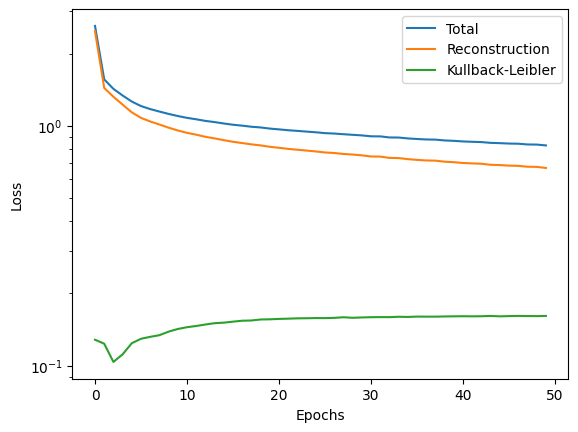

In [ ]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generation
----------

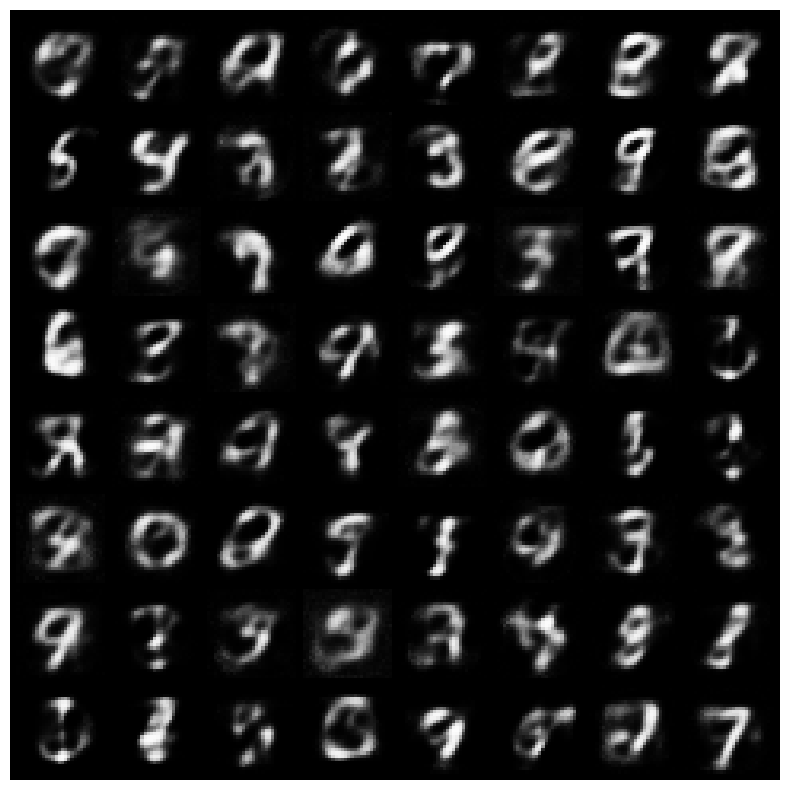

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**2, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**2, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = correct_shape(fake_image_batch)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

Visualization in Latent Space
-----------------------------

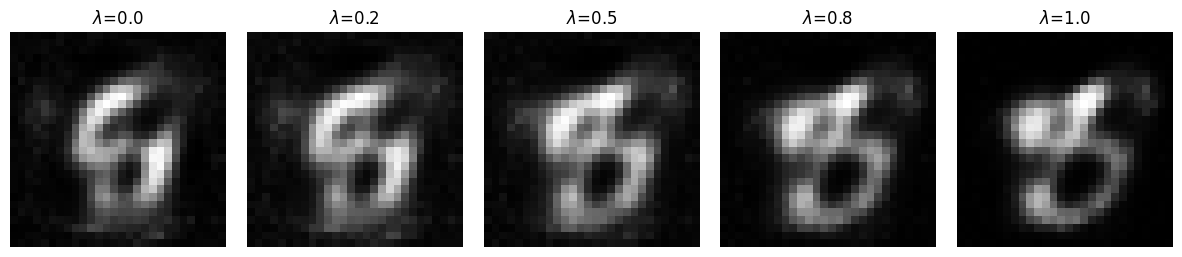

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()

def correct_shape(imgs):
  return imgs.view(-1, 28, 28).unsqueeze(1)

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn((1, latent_dim), device=device)
latent_2 = torch.randn((1, latent_dim), device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), p, latent_1, latent_2)

    inter_image = correct_shape(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()